In [303]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
    
def date_range(start, end, intv):
    """ 
    Splits date into intervals
    
    :param start: datetime - date from
    :param end: datetime- date to
    :param intv: int - num of intervals
    :return: yield data range
    """
    diff = (end - start) / intv
    for i in range(intv):
        yield (start + diff * i).strftime("%Y-%m-%d")
    yield end.strftime("%Y-%m-%d")


def draw_graph(result, title, type_data='Risk'):
    """
    Plots diagrams
    
    :param result: dict - key: column value, values: values in periods 
    :param title: string - title of plot
    :param type_data: string - label y axis
    """
    plt.figure(figsize=(16, 6))
    for key, value in result.items():
        plt.plot(list(value.keys()), list(value.values()), 'o-', label=key);
        for a, b in zip(list(value.keys()), list(value.values())):
            plt.text(a, b, str(np.round(b, 3)), fontsize=10, bbox=dict(facecolor='white', alpha=0.75))
    plt.title(title);
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    plt.xlabel('Date', fontsize=13);
    plt.ylabel(type_data, fontsize=13);
    if type_data != "Num of bads":
        plt.legend(fontsize=11);
    plt.show()


def plot_risk_categorical(df, target, columns_to_show=None, date_column=None, 
                          bad=None, data_bin_n=4, bin_by_month=False):
    """
    Plots risk diagrams of categorical columns by date
    
    :param df: pd.DataFrame - input data
    :param target: string - targets column name
    :param columns_to_show: list - targets column name
    :param date_column: string - targets column name
    :param bad: int or string - targets column name
    :param data_bin_n: int - number of data bins, data is split for equal values in bins
    :param bin_by_month: bool - if True month type of binning
    """
    # search columns to show
    if columns_to_show is None:
        columns_to_show = []
        for c in df.drop(target, axis=1).columns:
            if ('int' in str(df[c].dtype)) | ('float' in str(df[c].dtype)):
                columns_to_show.append(c)

    # search date_column to show
    if date_column is None:
        for c in df.drop(target, axis=1).columns:
            if (date_column is None) & ('date' in str(df[c].dtype)):
                date_column = c

    df = df.sort_values(by=date_column)
    for c in columns_to_show:
        #general statistic
        print(c + " risk's stats")
        print(df[df[target] == bad][c].value_counts() / df[c].value_counts())
        
        try:
            result = {}
            result_share = {}
            result_nums = {}
            for i in df[c].unique():
                df_sub = df[df[c] == i]
                if bin_by_month:
                    data_r = list(pd.date_range(min(df[date_column].dt.date), max(df[date_column].dt.date), freq='M'))
                else:
                    data_r = list(date_range(min(df[date_column]), max(df[date_column]), data_bin_n))

                period = {}
                period_share = {}
                period_nums = {}
                for j in range(1, len(data_r)):
                    df_sub_sub = df_sub[(df_sub[date_column] >= data_r[j - 1]) & (df_sub[date_column] < data_r[j])]
                    df_sq = df[(df[date_column] >= data_r[j - 1]) & (df[date_column] < data_r[j])]
                    if df_sub_sub.shape[0] == 0:
                        cur_res = 0
                    else:
                        cur_res = df_sub_sub[df_sub_sub[target] == bad].shape[0] / df_sub_sub.shape[0]
                    #period[pd.to_datetime(data_r[j - 1]).strftime('%d/%m/%Y') + ' -\n'
                    #               + pd.to_datetime(data_r[j]).strftime('%d/%m/%Y')] = cur_res
                        
                    period[pd.to_datetime(data_r[j - 1]).strftime('%d-%m-%Y')] = cur_res
                    
                    if df_sq.shape[0] == 0:
                        cur_res = 0
                    else:
                        cur_res = df_sq[df_sq[c] == i].shape[0] / df_sq.shape[0]
                        num_res = df_sq[df_sq[target] == bad].shape[0]
                    period_share[pd.to_datetime(data_r[j - 1]).strftime('%d-%m-%Y')] = cur_res
                    period_nums[pd.to_datetime(data_r[j - 1]).strftime('%d-%m-%Y')] = num_res
                result[i] = period
                result_share[i] = period_share
                result_nums[i] = period_nums

            draw_graph(result, c + " risk")
            draw_graph(result_share, c + " share", "Share")
            print()
            print()
        except Exception as e:
            print(repr(e))
            continue

    draw_graph(result_nums, "Number of incidents", "Num of bads")

In [291]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
df = pd.read_csv(url, header=None, na_values='?')
df.columns = [str('column_'+str(i)) for i in range(16)]

def random_dates(start, end, n=10):

    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime('2019-01-01')
end = pd.to_datetime('2020-01-01')
df['date'] = random_dates(start, end, data.shape[0])
df['risk'] = np.where(data.column_15=='+', 1, 0)

column_4 risk's stats
g     0.493256
p     0.276074
gg    1.000000
Name: column_4, dtype: float64


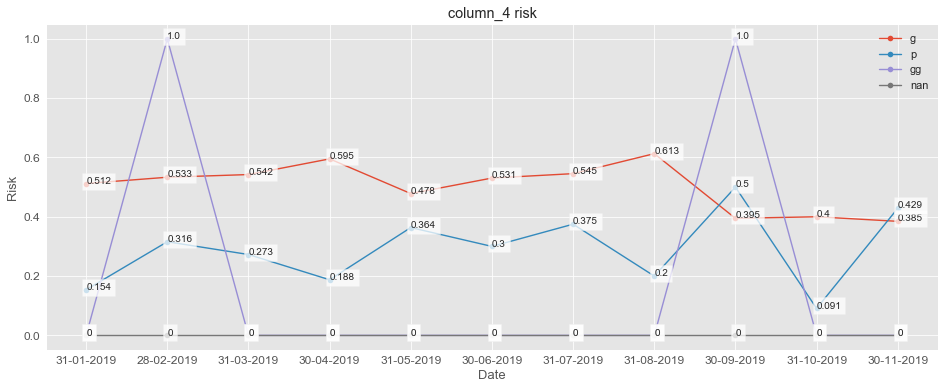

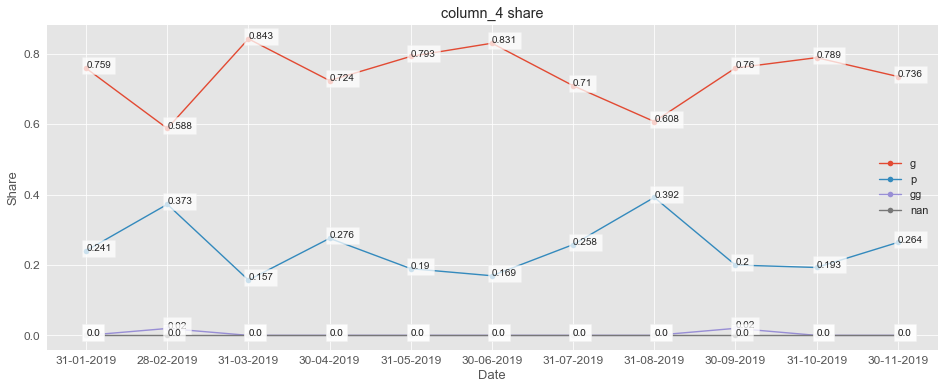



column_0 risk's stats
b    0.440171
a    0.466667
Name: column_0, dtype: float64


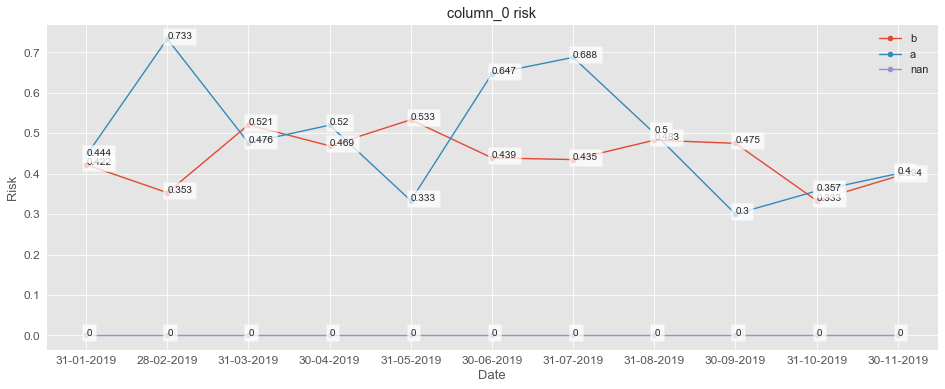

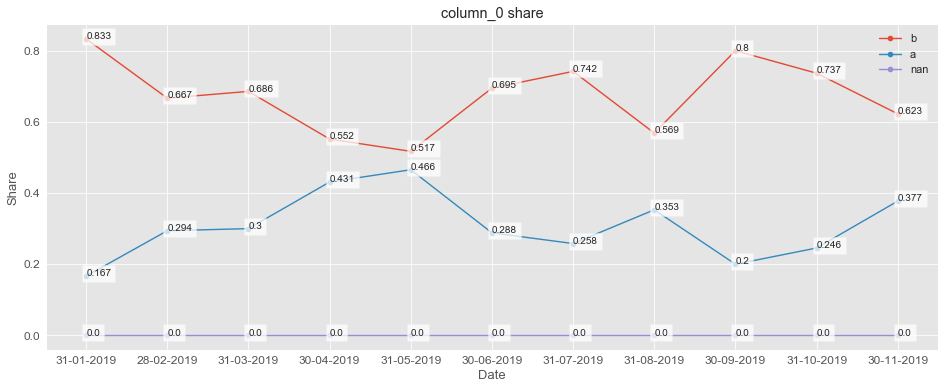

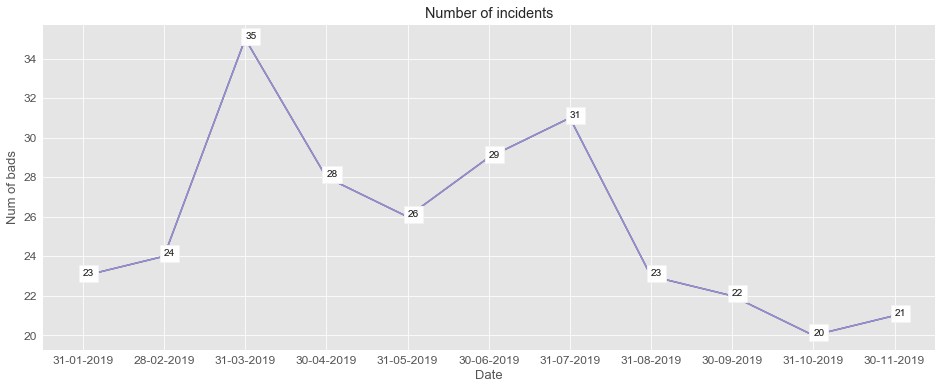

In [304]:
plot_risk_categorical(df, "risk", columns_to_show=['column_4','column_0'],
                      date_column='date', bad=1, data_bin_n=12, bin_by_month=True)